# Load Chat Model

In [1]:
!pip install -qU "langchain[google-genai]"

from google.colab import userdata

# Retrieve the Gemini API key from Colab's user data
gemini_api_key = userdata.get('gemini')

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai",google_api_key=gemini_api_key)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


# Load Documents

In [2]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red color", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

# Create Graph

In [3]:
!pip install -qU langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 9.3 MB/s eta 0:00:00


In [4]:
# METHOD of It Ref
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

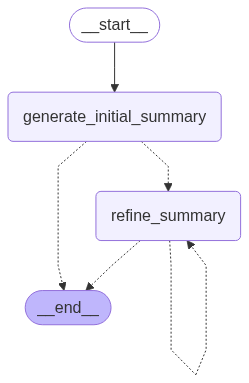

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

# Invoke Graph

In [8]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Apples are red.
Apples are red, and blueberries are blue.
Apples are red, blueberries are blue, and bananas are yellow.
